# 背景介绍

假设某一通信运营商，要在业务中使用数据科学，想要部署ML模型。

通过结合用户行为数据和分类算法来创建用户流失模型，对当前用户进行流失预测。

# 定义ML目标

用户流失指的是用户不再使用企业提供的服务或迁移到竞争对手那里。对于任何企业而言，留存和吸引系用户都是企业运营核心。

该项目的业务目标就是分析用户相关数据，开发一个ML用户流失预测模型，识别出高流失风险的用户，并找出影响用户流失的主要指标，以辅助运营决策，制定降低用户流失率的策略。

## 业务目标

利用前三个月的特征数据预估第四个月的用户流失倾向。

## ML目标

* 探索用户流失前可能会表现出的异常行为：用户通常不会立即决定转向其他竞争对手，而是经过一定时间后才决定转向，这一点尤其适用于高价值用户。捕捉用户流失前的行为变化对特征的模型构建至关重要。
* 建立回归/分类模型预测用户流失：基于用户的历史行为数据构建用户流失预测模型

# 数据收集


## 数据获取

数据集包括4个csv文件：
* 用户流失数据
* 用户人口统计数据
* 互联网合约数据
* 元数据（数据字典）

## 加载数据

In [1]:
import pandas as pd

# 控制Pandas在notebook的显示,行列不会折叠
pd.options.display.max_columns = None
pd.options.display.max_rows = 10

* 加载流失数据

In [2]:
# 流失数据主表，包含主要信息
churn_df = pd.read_csv("../data/churn_data.csv")
print("数据维度信息: {}".format(churn_df.shape))
churn_df.head()

数据维度信息: (7043, 9)


,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


* 加载用户人口统计数据

In [3]:
# 用户人口统计数据
customer = pd.read_csv("../data/customer_data.csv")
print("数据维度信息：{}".format(customer.shape))
customer.head()

数据维度信息：(7043, 5)


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


* 加载互联网合约数据

In [4]:
# 互联网合约数据
contract = pd.read_csv("../data/internet_data.csv")
print("数据维度信息：{}".format(contract.shape))
contract.head()

数据维度信息：(7043, 9)


,customerID,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,No,Fiber optic,No,No,No,No,No,No


* 加载元数据

In [5]:
# 数据字典
meta = pd.read_csv("../data/Telecom Churn Data Dictionary.csv")
meta.head()

,S.No.,VariableName,Meaning
0,1,CustomerID,The unique ID of each customer
1,2,Gender,The gender of a person
2,3,SeniorCitizen,Whether a customer can be classified as a seni...
3,4,Partner,If a customer is married/ in a live-in relatio...
4,5,Dependents,If a customer has dependents (children/ retire...


* 接下来需要将3个表合并成一个宽表，customerID作为索引

In [6]:
# 设置索引
for i in [churn_df, customer, contract]:
    i.set_index("customerID", inplace=True)

churn_df.head()

,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,
7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
# 连接三个数据文件，一个接一个，以customerID作为索引
df = churn_df.join(customer).join(contract)

# 确保没有1：N的关系，即没有重复，再次打印数据维度
print("整合后的数据维度信息：{}".format(df.shape))
df.head()

整合后的数据维度信息：(7043, 20)


,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,0,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,0,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


# 数据预处理

## 缺失值处理

In [8]:
df.dtypes

tenure               int64
PhoneService        object
Contract            object
PaperlessBilling    object
PaymentMethod       object
                     ...  
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
Length: 20, dtype: object

In [9]:
df.describe()

,tenure,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,0.162147
std,24.559481,30.090047,0.368612
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,0.000000
50%,29.000000,70.350000,0.000000
75%,55.000000,89.850000,0.000000
max,72.000000,118.750000,1.000000


In [10]:
# 定义方法来统计缺失值
def check_stats(df):
    '''
    返回一个显示主要统计数据和附加指标的表格（数据框）
    '''
    # 把数据类型储存在一个独立的数据框架中
    df_info = pd.DataFrame(df.dtypes, columns=["dtypes"])
    
    # 计算缺失记录总和
    df_info = df_info.join((df.replace({'':None,' ':None}) if "('O')" in str(df.dtypes.values) else df).isna().sum().rename("isna"))
    
    # 在最后一步添加统计数据（仅对数值列进行计算）
    return df_info.T.append(df.describe(),sort=False)

check_stats(df).T.query("isna != 0")

,dtypes,isna,count,mean,std,min,25%,50%,75%,max
TotalCharges,object,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# # 对缺失进行处理
# import numpy as np
# df.TotalCharges = df.TotalCharges.replace(to_repalce=np.nan,value=df.TotalCharges.median())

# # TypeError: could not convert string to float:

类型不对，需要进行转换

In [12]:
telco2 = df.copy()
# we are converting all the values in the TotalCharges data to float, 
# However, for blank strings we are going to impute nan ... errors= 'coerce'
telco2['TotalCharges'] = pd.to_numeric(telco2['TotalCharges'],errors= 'coerce')

In [13]:
import numpy as np
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors= 'coerce')
df.TotalCharges = df.TotalCharges.replace(to_replace=np.nan, value= df.TotalCharges.median())
check_stats(df).T.query("isna != 0")

,dtypes,isna,count,mean,std,min,25%,50%,75%,max


In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.000,29.000,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.500,70.350,89.85,118.75
TotalCharges,7043.0,2281.916928,2265.270398,18.80,402.225,1397.475,3786.60,8684.80
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.000,0.000,0.00,1.00


## 离群值检测

离群值是原理分布或者平均值的观测值，但他们不一定代表异常行为。

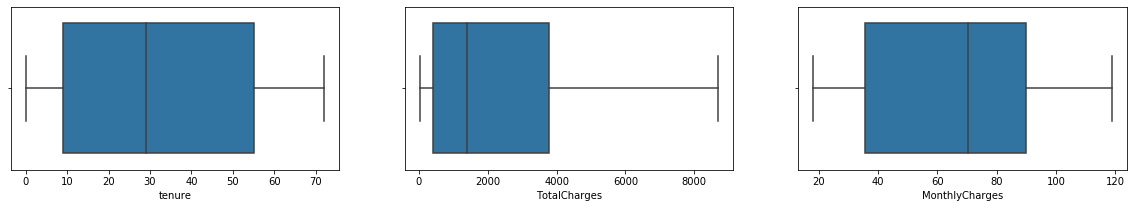

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# 对数值型变量进行离群值检测
plt.figure(figsize=(20,3))

plt.subplot(1,3,1)
sns.boxplot(df.tenure)

plt.subplot(1,3,2)
sns.boxplot(df.TotalCharges)

plt.subplot(1,3,3)
sns.boxplot(df.MonthlyCharges)

plt.show()

发现总消费额（TotalCharges）分布是有偏的。

In [16]:
# 关注5%-95%的总消费额数据
perc5 = round(np.percentile(df['TotalCharges'],5),2)
perc95 = round(np.percentile(df['TotalCharges'],95),2)
print("重点关注总费用介于{}与{}之间的用户".format(perc5,perc95))

重点关注总费用介于49.65与6921.02之间的用户


In [17]:
# 过滤数据集
df = df.loc[(df['TotalCharges'] <= perc95) & (df['TotalCharges'] >= perc5)]
df.shape

(6338, 20)

# 数据探索

从业务角度分析可能导致用户流失的因素：
* 服务方面：当前服务不能满足用户的需求或竞争对手拥有更适合用户的服务。
* 用户方面：用户的需求发生了变化，比如，之前的主要需求是打电话，现在换为智能手机，需求更偏向于使用流量。

## 目标变量

首先对目标变量进行简要的分析，初步了解当前样本的用户流失情况，比如查看流失用户占比。

Rectangle(xy=(0, -0.4), width=4655, height=0.8, angle=0)
Rectangle(xy=(0, 0.6), width=1683, height=0.8, angle=0)


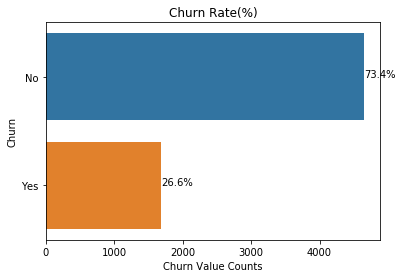

In [18]:
def bar_plot(df,column):
    ax = sns.countplot(y=column, data=df)
    plt.title('Churn Rate(%)')
    plt.xlabel('Churn Value Counts')
    
    total = len(df[column])
    for p in ax.patches:
        print(p)
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height() / 2
        ax.annotate(percentage,(x,y))
    plt.show()
bar_plot(df,'Churn')

我们发现流失用户占比26.6%，非流失用户占比73.4%，发现目标存在不平衡情况。

## 服务分析

对当前样本中正常用户和流失用户接受网络服务的情况进行简要分析。

[Text(0, 0, 'DSL'),
 Text(0, 0, 'Fiber optic'),
 Text(0, 0, 'Not receiving internet service')]

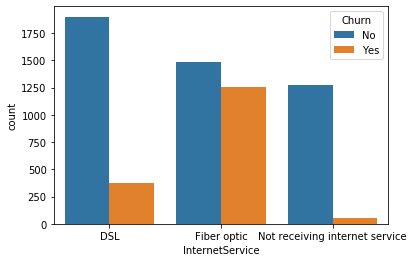

In [19]:
ax = sns.countplot(x='InternetService',hue='Churn',data=df,order=['DSL','Fiber optic','No'])
ax.set_xticklabels(['DSL','Fiber optic','Not receiving internet service'])

接受网络服务的的用户流失率明显高于未接受网络服务的，尤其是使用了光纤（Fiber optic）的流失率达到了40%，所以这个服务可能存在一定的问题。

对于网络服务，可以进一步探讨是否有其他附加服务会影响用户的流失率。比如，使用网络服务的用户对网络安全、网络备份、设备保护、技术支持等增值业务为付费情况：

[Text(0, 0.5, 'Num of churns'), Text(0.5, 0, 'Additional service')]

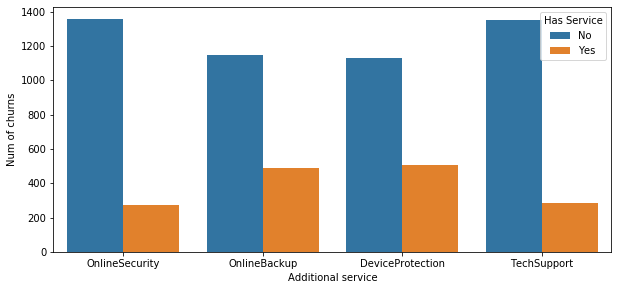

In [20]:
cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport"]
plt.figure(figsize=(10,4.5))
df_new  = df.copy()

# 筛选出使用网络服务的并且是流失用户的数据
df_service = df_new[(df_new.InternetService != "No") & (df_new.Churn == "Yes")]

# pd.melt 将多列合并，也就是把cols的值编程variable的值，value就是源数据的Yes或No
df_service = pd.melt(df_service[cols]).rename({'value':'Has Service'},axis=1)

ax = sns.countplot(data=df_service, x='variable',hue='Has Service',hue_order=['No','Yes'])
ax.set(xlabel='Additional service',ylabel='Num of churns')

我们可以发现，使用网络服务的用户如果使用了4种附加服务，将有效降低其流失的可能性。

我们可以通过以上分析进行总结：是否使用网络服务，以及在网络服务中是否使用附加服务，这两点对流失用户有较大的相关性。

## 用户行为分析

从用户行为的角度来看，可能与用户流失有关的指标有：合同期、在网时长、支付方式、月消费额、总消费额等。

其中**合同期、在网时长、总消费额**可以较好反映用户对通信服务的**忠诚度**；用户的支付方式、月销售额则可以反映用户的**消费观念**。

### 对数值型特征进行密度分析
首先对在网时长（tenure）、月消费额（MonthlyCharges）、总消费额（TotalCharges）三个数值型特征做密度分析。用密度图比较流失和非流失两类人群在这三个特征上的表现。

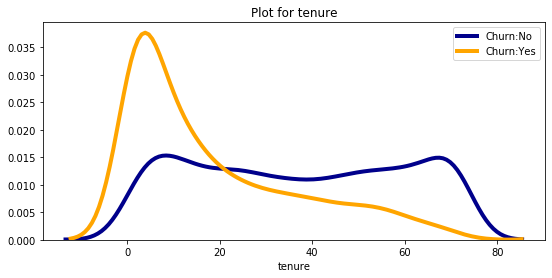

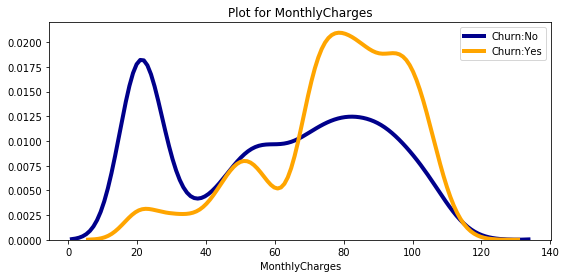

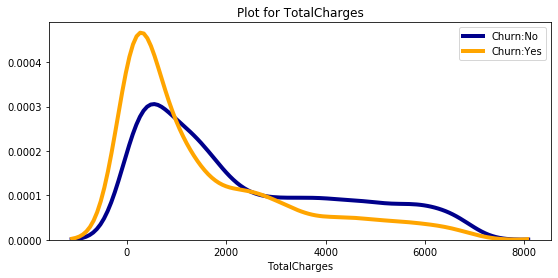

In [21]:
def kdeplot(feature, hist, kde):
    plt.figure(figsize=(9,4))
    plt.title("Plot for {}".format(feature))
    ax0 = sns.distplot(df[df['Churn'] == 'No'][feature].dropna(),hist=hist, 
                    kde=kde,color='darkblue', label='Churn:No', 
                    hist_kws={'edgecolor':'black'},
                    kde_kws={'linewidth':4})
    
    ax1 = sns.distplot(df[df['Churn'] == 'Yes'][feature].dropna(),hist=hist, 
                    kde=kde,color='orange', label='Churn:Yes', 
                    hist_kws={'edgecolor':'black'},
                    kde_kws={'linewidth':4})
    
kdeplot('tenure',hist=False, kde=True)
kdeplot('MonthlyCharges', hist=False, kde=True)
kdeplot('TotalCharges', hist=False, kde=True)

从上面三图可以分析得出，主要看黄线（流失用户）：
* tenure（在网时长）短的用户更容易流失
* MonthlyCharges（月销售额）较高的用户更容易流失
* TotalCharges（总销售额）两者比较接近

### 从在网时长（tenure）进行分析

我们可以观察到在网时长（tenure）的合约月数，我们可以进行简单分箱，暂时将其分为4个组合：
* 0-12月
* 12-24月
* 24-48月
* 48月以上

当然也可采用其他分箱方式，这里暂不赘述。

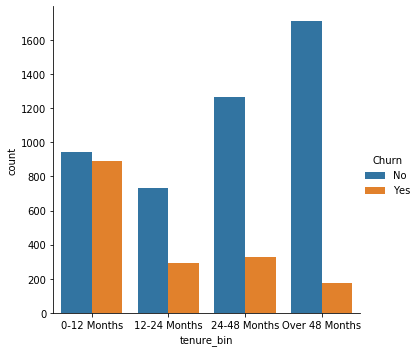

In [22]:
def bin_group(tenure):
    if tenure < 13:
        return "0-12 Months"
    elif tenure < 25:
        return "12-24 Months"
    elif tenure < 49:
        return "24-48 Months"
    else:
        return "Over 48 Months"

df_bins = df.copy()
df_bins["tenure_bin"] = df_bins["tenure"].apply(bin_group)

sns.catplot(data=df_bins, x='tenure_bin', hue="Churn", kind="count", 
            order=['0-12 Months','12-24 Months','24-48 Months','Over 48 Months'])
plt.show()

我们可以观察到，0-12月的tenure的流失率极高，对比其他的合约时长。

### 从支付角度（PaymentMethod）分析

我们也可以从支付方式的角度分析用户流失情况，看看正常用户与流失用户之间是否有显著差异。

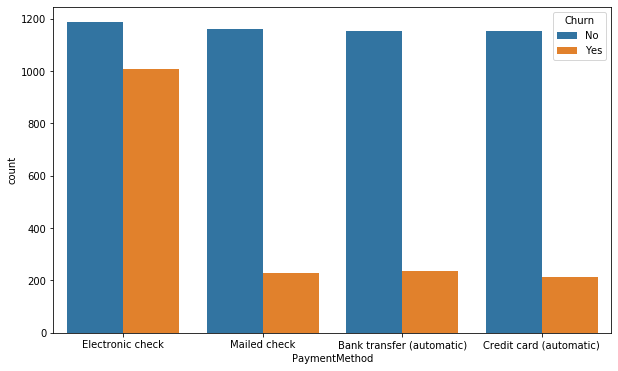

In [23]:
plt.figure(figsize=(10.,6))
sns.countplot(x='PaymentMethod', hue='Churn', data=df,
             order=['Electronic check','Mailed check','Bank transfer (automatic)',
                   'Credit card (automatic)'])

我们发现使用电子支票的用户流失率显著高于使用其他支付方式的用户

# 特征工程

特征工程师ML工作流中重要的组成部分，它将原始数据映射成模型可理解的形式，并尽可能地提取处原始数据包含的信息，以更好地表达业务逻辑及提高ML性能。

特征工程是一个超集，包括特征提取、特征构建、特征选择三个子模块。在实践中，每一个模块都不能忽视。通常来说，三个子模块的相对重要性排序：特征构建>特征提取>特征选择。

该模块主要说明的ML的构建流程，所以对于特征工程仅对特征构建做简要阐述。

## 分类和数值列拆分

首先构建一个用特征源数据描述的函数，以对当前数据的基本信息进行探索：

In [24]:
def df_feat_summary(df):
    summary = pd.DataFrame({"number_of_unique":[],"first_5_unique":[]})
    for i in df.columns:
        summary = pd.concat([summary,
                             pd.DataFrame({"number_of_unique":[len(df[i].unique())],
                                            "first_5_unique":[str(df[i].unique()[0:5])]},index=[i])],
                            sort=False)
    return summary

df_feat_summary(df)

,number_of_unique,first_5_unique
tenure,73.0,[34 2 45 8 22]
PhoneService,2.0,['Yes' 'No']
Contract,3.0,['One year' 'Month-to-month' 'Two year']
PaperlessBilling,2.0,['No' 'Yes']
PaymentMethod,4.0,['Mailed check' 'Bank transfer (automatic)' 'E...
...,...,...
OnlineBackup,3.0,['No' 'Yes' 'No internet service']
DeviceProtection,3.0,['Yes' 'No' 'No internet service']
TechSupport,3.0,['No' 'Yes' 'No internet service']
StreamingTV,3.0,['No' 'Yes' 'No internet service']


查看数据集中各特征唯一值的数量，为确定特征类型提供依据。为简化数据处理复杂度，本项目将唯一值小于10的特征归为分类特征，唯一值数量大于或等于10且值为数字的特征归为数值型特征。

然后，进一步将分类型特征与数值型特征分开，以便后续进行特征处理的时候更容易实现自动化。

In [25]:
#Identifier and target variable
telco =df.copy()
customer_id=['customerID']
target=['Churn']

#Split categorical and numerical column NAMES as lists
categories=telco.nunique()[telco.nunique()<10].keys().tolist()
categories.remove(target[0])
numerical=[col for col in telco.columns if col not in customer_id+target+categories]
print("分类型特征:\n{}\n".format(categories))
print("数值型特征:\n{}".format(numerical))

分类型特征:
['PhoneService', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

数值型特征:
['tenure', 'MonthlyCharges', 'TotalCharges']


## One-Hot 编码

接下来需要对分类型特征进行预处理。有些ML算法可以在不进行任何预处理的情况下对分类型特征进行操作（如决策树、贝叶斯等），但大多数算法只能处理数值型特征。

In [26]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Here is a for loop that will convert all remaining columns applying OneHotEncoder
# we will "declare" the encoder just to use its 'categories_' attribute 
#numerical1=numerical.append("SeniorCitizen")
train_c = df[categories]
train_n = df[numerical]
ohe = OneHotEncoder() 
for i in categories:
        print(i)
        # fit = get new mapping for each column
        ohe = OneHotEncoder().fit(df[i].unique().reshape(-1,1))
        # OneHotEncoder (just like ML models) expects/require a numpy matrix/array as input
        temp = pd.DataFrame(ohe.transform(df[i].to_numpy().reshape(-1,1)).toarray(),
                            index=df.index,
                            columns=[i+"_"+str(cat).lower().replace(" ","_") for cat in ohe.categories_[0]])
        # Check also category-encoders library for easier encoding
        train_n = train_n.join(temp)
        #test_e = test_e.join(temp)

PhoneService
Contract
PaperlessBilling
PaymentMethod
gender
SeniorCitizen
Partner
Dependents
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies


In [27]:
train_n

,tenure,MonthlyCharges,TotalCharges,PhoneService_no,PhoneService_yes,Contract_month-to-month,Contract_one_year,Contract_two_year,PaperlessBilling_no,PaperlessBilling_yes,PaymentMethod_bank_transfer_(automatic),PaymentMethod_credit_card_(automatic),PaymentMethod_electronic_check,PaymentMethod_mailed_check,gender_female,gender_male,SeniorCitizen_0,SeniorCitizen_1,Partner_no,Partner_yes,Dependents_no,Dependents_yes,MultipleLines_no,MultipleLines_no_phone_service,MultipleLines_yes,InternetService_dsl,InternetService_fiber_optic,InternetService_no,OnlineSecurity_no,OnlineSecurity_no_internet_service,OnlineSecurity_yes,OnlineBackup_no,OnlineBackup_no_internet_service,OnlineBackup_yes,DeviceProtection_no,DeviceProtection_no_internet_service,DeviceProtection_yes,TechSupport_no,TechSupport_no_internet_service,TechSupport_yes,StreamingTV_no,StreamingTV_no_internet_service,StreamingTV_yes,StreamingMovies_no,StreamingMovies_no_internet_service,StreamingMovies_yes
customerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5575-GNVDE,34,56.95,1889.50,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3668-QPYBK,2,53.85,108.15,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7795-CFOCW,45,42.30,1840.75,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
9237-HQITU,2,70.70,151.65,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9305-CDSKC,8,99.65,820.50,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2569-WGERO,72,21.15,1419.40,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6840-RESVB,24,84.80,1990.50,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4801-JZAZL,11,29.60,346.45,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


One-Hot 编码也可以使用pd.get_dummies()。虽然pd.get_dummies()简单，但是不能进行持久化，所以不能进行推理，仅适合对单一数据集进行简单分析。

使用OneHotEncoder的好处在于，可以持久化训练集中的参数，相当于特征处理的元数据和处理逻辑，在生产中进行模型预测的时候，可以直接使用这个用来处理实时数据流。

两者的返回类型也不同，pd.get_dummies()返还的是一个DataFrame，OneHotEncoder返回的是数组。

One-Hot编码处理后的结果在默认的情况下是稀疏向量（sparse=True），将类别的索引的值为1，其他位置的每个值为0，这种编码解决了数值化问题，但缺点是会占用较大的内存。投产时，建议使用稠密模式（sparse=False，后面不用to_array()），这样可以极大地降低内存占用率，且源数据的稠密程度越高，减少的内存也越大。

## 特征缩放处理

特征缩放的目的是将可用范围的数值型特征的范围映射到一个有特定规则或分布的数据点上。最常用的数据缩放技术就是归一化和标准化。

* 归一化：比如想要把结果约束在[0,1]中间就可以用min-max Scaler
* 标准化：将原数据映射到正态分布上，StandardScaler

这些过程对于ML优化方面很有用，对于使用梯度下降优化的ML算法，使用缩放后的特征训练的收敛速度要比之前要快得多。

In [28]:
from sklearn.preprocessing import StandardScaler

# It makes, of course, only sense to apply scaling only to numerical values
# Again, "fit" on train and apply/"transform" test
train_nn=train_n.copy()
scaler = StandardScaler()
for i in [numerical]:
    train_nn[i] = scaler.fit_transform(train_nn[i])
    #test_e[i] = scaler.transform(test_e[i])

In [29]:
train_nn

,tenure,MonthlyCharges,TotalCharges,PhoneService_no,PhoneService_yes,Contract_month-to-month,Contract_one_year,Contract_two_year,PaperlessBilling_no,PaperlessBilling_yes,PaymentMethod_bank_transfer_(automatic),PaymentMethod_credit_card_(automatic),PaymentMethod_electronic_check,PaymentMethod_mailed_check,gender_female,gender_male,SeniorCitizen_0,SeniorCitizen_1,Partner_no,Partner_yes,Dependents_no,Dependents_yes,MultipleLines_no,MultipleLines_no_phone_service,MultipleLines_yes,InternetService_dsl,InternetService_fiber_optic,InternetService_no,OnlineSecurity_no,OnlineSecurity_no_internet_service,OnlineSecurity_yes,OnlineBackup_no,OnlineBackup_no_internet_service,OnlineBackup_yes,DeviceProtection_no,DeviceProtection_no_internet_service,DeviceProtection_yes,TechSupport_no,TechSupport_no_internet_service,TechSupport_yes,StreamingTV_no,StreamingTV_no_internet_service,StreamingTV_yes,StreamingMovies_no,StreamingMovies_no_internet_service,StreamingMovies_yes
customerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5575-GNVDE,0.085116,-0.259798,-0.113221,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3668-QPYBK,-1.294810,-0.368570,-1.027473,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7795-CFOCW,0.559466,-0.773832,-0.138241,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
9237-HQITU,-1.294810,0.222657,-1.005147,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9305-CDSKC,-1.036074,1.238445,-0.661870,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2569-WGERO,1.723778,-1.515936,-0.354493,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6840-RESVB,-0.346111,0.717393,-0.061384,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4801-JZAZL,-0.906706,-1.219445,-0.905169,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## 目标变量

当前数据中目标变量的值为[No,Yes]，可以使用LabelEncoder进行编码。

In [30]:
Y = df['Churn']
# 确保No是0，Yes是1
le = LabelEncoder().fit(['No','Yes'])
y = le.transform(Y)

In [31]:
y

array([0, 1, 0, ..., 0, 1, 0])

## 样本生成

最后将数据分布分成训练集和测试集

In [32]:
from sklearn.model_selection import train_test_split

train_X,test_X,train_y,test_y=train_test_split(train_nn,y,test_size=0.3)

print(train_X.shape[0]/train_nn.shape[0])
print(test_X.shape[0]/train_nn.shape[0])

0.6999053329125907
0.3000946670874093


# 构建和评估模型

在实际场景中，需要用到实际的数据集测试不同的模型，探索出最能拟合当前数据的模型。维数据选择模型没有硬性或快速的规则，它总是取决于数据集和不断的探索。

## 处理非平衡数据集

非平衡数据集在实际场景中十分常见，它可以显著的影响模型的性能，与算法无关。通常而言，如果数据集中每个类别的占比差不多的，我们可以认为它为平衡数据集，安装正常样本进行样本分割就可，比如60%-40%。当占比超过10:1，样本的非平衡程度较高时，就需要用重采样的方法，一般分为欠采样和过采样，imblearn这个包是专门用来处理非平衡数据集的。
* 欠采样：丢弃大量数据，和过采样一样会存在过拟合的问题。
* 过采样：重复正比例数据，实际上没有为模型引入更多数据，过分强调正比例数据，会放大正比例噪音对模型的影响，常用SMOTE。

所以接下来，例子就用SMOTE来处理不平衡数据集的问题。

## 模型构建

In [33]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [34]:
def build_model(X,y,algorithm,imb_class):
    # imbalanced datasets
    if imb_class == 1:
        oversample = SMOTE()
        X, y = oversample.fit_resample(X, y)
    
    # train_test_split
    train_X,test_X,train_y,test_y=train_test_split(X,y,test_size=0.2, random_state=6)
    
    # algorithm selections
    if algorithm == 'LogisticRegression':
        model = LogisticRegression(max_iter=1000)
    if algorithm == 'RandomForest':
        model = RandomForestClassifier(n_estimators=1000)
    if algorithm == 'NaiveBayes':
        model = GaussianNB()
    
    # fit model
    fitted_model = model.fit(train_X, train_y)
    y_pred = fitted_model.predict(test_X)
    
    # metrics
    precision = round(precision_score(test_y,y_pred),2)
    recall = round(recall_score(test_y,y_pred),2)
    fscore = round(f1_score(test_y,y_pred),2)
    accuracy = round(accuracy_score(test_y,y_pred),2)
    
    return precision, recall, fscore, accuracy, fitted_model

In [35]:
columns = ['ML算法','SMOTE过采样','precision','recall','f1 score','accuracy']
model_efficacy = pd.DataFrame(columns=columns)

X = train_nn
y = y
model_fitted = {}

for i in range(0,2):
    alg = ['LogisticRegression','RandomForest','NaiveBayes']
    for j in range(0,len(alg)):
        if i == 0:
            if_smote = 'no_smote'
        else:
            if_smote = 'smote'
        
        algorithm = alg[j]
        print('{}_{}'.format(algorithm,if_smote))
        
        precision, recall, fscore, accuracy,model_fitted['{}_{}'.format(algorithm,if_smote)]= build_model(X,y,algorithm,i)
        
        new_row = {'ML算法':algorithm,'SMOTE过采样':if_smote,'precision':precision,
                  'recall':recall, 'f1 score':fscore, 'accuracy':accuracy}
        model_efficacy = model_efficacy.append(new_row, ignore_index=True)

model_efficacy

LogisticRegression_no_smote
RandomForest_no_smote
NaiveBayes_no_smote
LogisticRegression_smote
RandomForest_smote
NaiveBayes_smote


,ML算法,SMOTE过采样,precision,recall,f1 score,accuracy
0,LogisticRegression,no_smote,0.62,0.60,0.61,0.80
1,RandomForest,no_smote,0.61,0.50,0.55,0.79
2,NaiveBayes,no_smote,0.43,0.91,0.59,0.67
3,LogisticRegression,smote,0.73,0.85,0.79,0.78
4,RandomForest,smote,0.85,0.87,0.86,0.86
5,NaiveBayes,smote,0.67,0.90,0.77,0.75


从结果可以看出，SMOTE过采样的表现优于原始数据，其中在使用SMOTE的不同算法中，随机森林效果最好。

最后，从上述模型评估结果中，挑选出来较优的算法，并定义一个特征重要性选择函数（feature_imp），计算所用特征对模型的重要性排名：

In [36]:
def feature_importance(df, model):
    fi = pd.DataFrame()
    fi['feature'] = df.columns
    fi['importance'] = model.feature_importances_
    return fi.sort_values(by='importance',ascending=False)

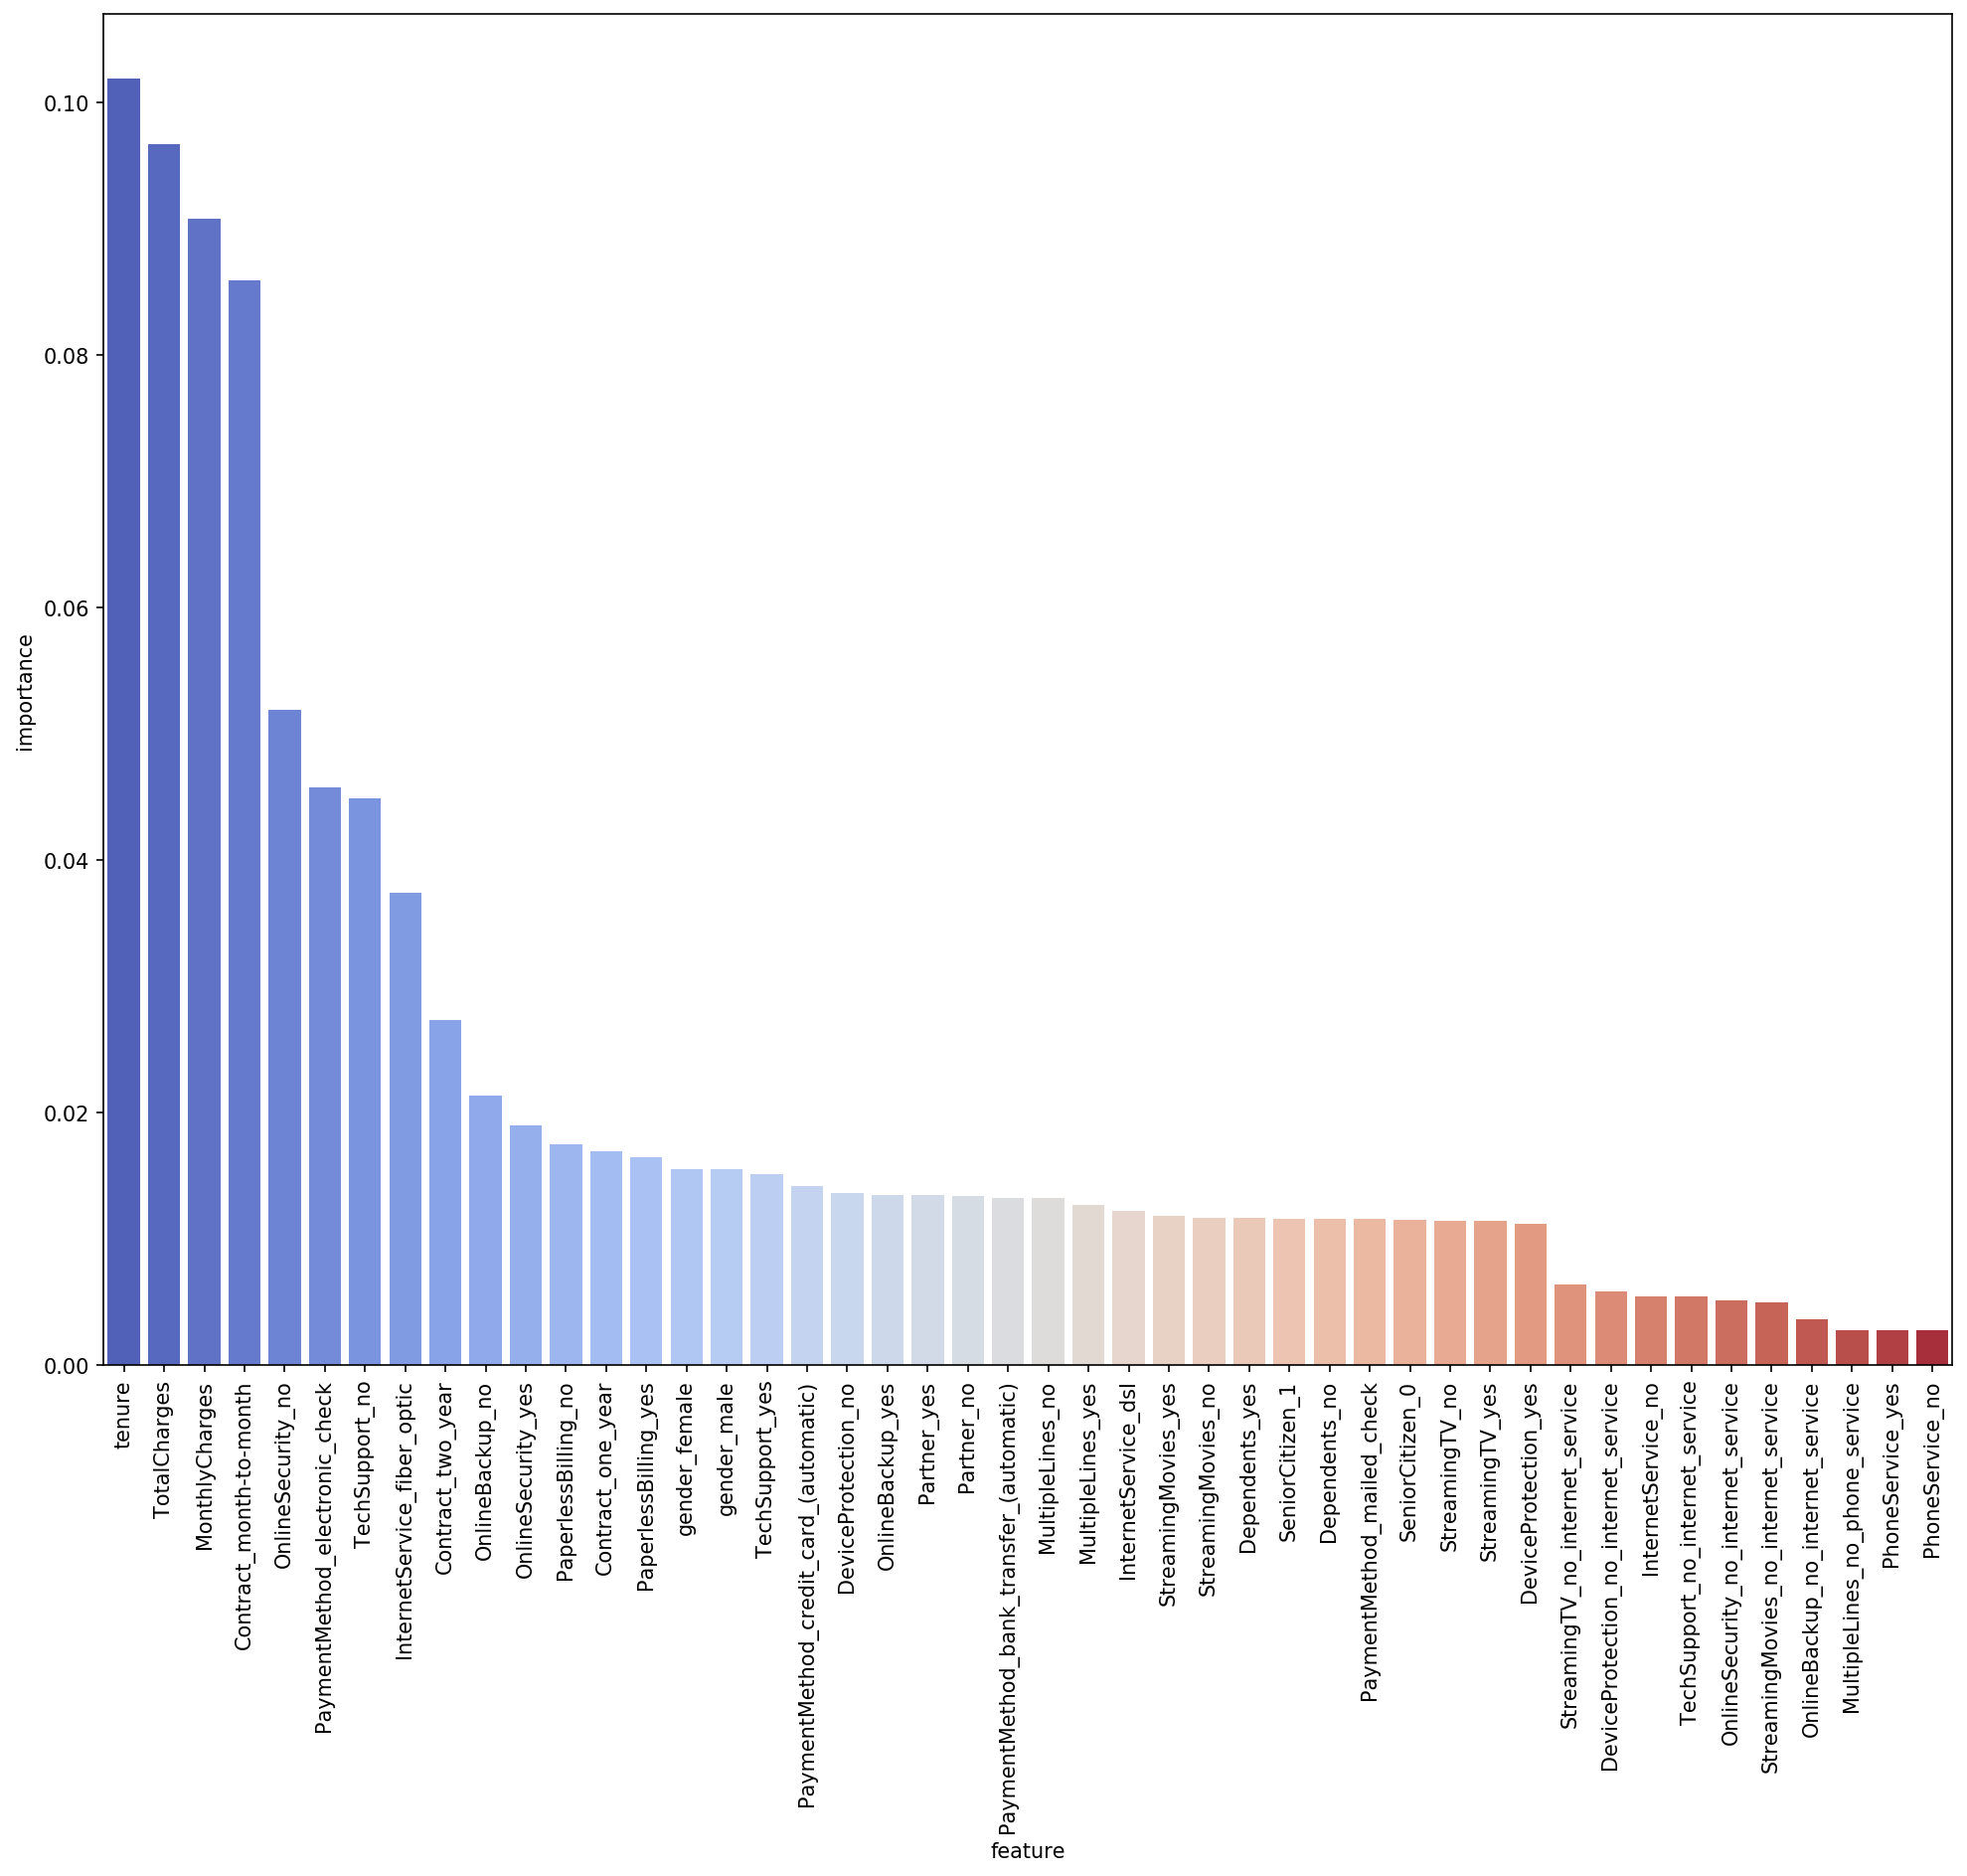

In [38]:
rf_clf = model_fitted['RandomForest_smote']
df_feature_importance = feature_importance(X, rf_clf)

plt.figure(figsize=(16,12),dpi=150)
sns.barplot(data=df_feature_importance, x=df_feature_importance.feature, y='importance',palette='coolwarm')
plt.xticks(rotation=90)
plt.show()

通过随机森林的特征重要性来排序，在网时长、总消费额、月消费额对模型的贡献较大。

# 持久化模型

我们现在训练好了一个模型，需要储存（持久化）它，使得我们可以重复使用它。同时，我们还有一个数据变换器，也需要被存储。

In [39]:
import pickle

def save_model(model, path='model.pkl'):
    with open(path, 'wb') as f:
        pickle.dump(model,f)
        print('Saved model at {}'.format(path))

save_model(rf_clf)

with open('./ohe.pkl','wb') as f:
    pickle.dump(ohe,f)
    
with open('./scaler.pkl','wb') as f:
    pickle.dump(scaler,f)

Saved model at model.pkl


接下来我们可以把模型部署成一个REST API，为了方便特征工程的持久化，下面使用make_column_transformer函数对特征工程创建简单的管道，以实现统一的转化：

In [40]:
from sklearn.compose import make_column_transformer

transformer = make_column_transformer(
    (scaler, numerical),
    (ohe,categories)
)

df_trans =df.drop(columns='Churn')
transformer.fit(df_trans)

with open('./transformer.pkl','wb') as f:
    pickle.dump(transformer,f)

# 构建 REST API

在模型构建好之后，可以通过主动和被动两种消费模型：
* 被动（拉取）：终端用户除法请求，从ML模型中“拉取结果”，一般方式是部署为微服务（REST API）
* 主动（推送）：模型结果以通知或预警的形式“推送”给终端用户。比如一个异常检测，检测实时数据，发现异常数据就主动触发警报。

拉取机制更常见一点，在实际应用中，ML只是系统的一部分，为业务需求提供服务，真正的业务逻辑通常发生在业务系统中。

接下来以REST API实现模型部署和应用为例来介绍。具体方式是，通过制作一个简单的Flask应用程序来创建基本的应用程序，并在Flask应用程序的后端托管刚训练好的模型。

## 编写预测函数

在server.py，创建一个/predict的端点。这个端点将接受用户请求的数据，调用后端加载的模型产生预测，并将预测结果作为JSON响应返回，可以设置请求方式为POST。

**注意，这里的模型和持久化了的特征工程逻辑及其元数据是加载在内存中的，这以为着更新模型需要先将老模型卸载。所以，后续在生产中零停机更新模型需要有解决方案。**

下面的代码保存在py文件里，在命令行运行。

In [41]:
from flask import Flask, jsonify, request
import pandas as pd
import pickle
import sklearn
app = Flask(__name__)

def load_obj(path):
    with open(path,"rb") as f:
        obj = pickle.load(f)
    return obj
model = load_obj('model.pkl')
transformer = load_obj('transformer.pkl')

# categories = ['PhoneService', 'Contract', 'PaperlessBilling', 
#               'PaymentMethod', 'gender', 'Partner', 
#               'Dependents', 'MultipleLines', 'InternetService',
#               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
#               'TechSupport', 'StreamingTV', 'StreamingMovies']
# numerical = ['tenure', 'MonthlyCharges', 'TotalCharges','SeniorCitizen']

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    df = pd.DataFrame(data, index=[0])
    X = transformer.transform(df)
    predicted_churn = model.predict(X)[0]
    predicted_proba_churn = model.predict_proba(X)[0][0]
    return jsonify({"predicted_churn": str(predicted_churn),
                    "predicted_proba_churn":str(predicted_proba_churn)})

if __name__ == '__main__':
     app.run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


## 用户请求测试

用户如何访问你的REST API，从而获得预测结果。

In [43]:
import requests
import json

url = 'http://127.0.0.1:5000/predict'
data ={"tenure":1,
         "PhoneService":"No",
         "Contract":"Month-to-month",
         "PaperlessBilling":"Yes",
         "PaymentMethod":"Electronic check",
         "MonthlyCharges":29.85,
         "TotalCharges":29.85,
         "gender":"Female",
         "SeniorCitizen":0,
         "Partner":"Yes",
         "Dependents":"No",
         "MultipleLines":"No phone service",
         "InternetService":"DSL",
         "OnlineSecurity":"No",
         "OnlineBackup":"Yes",
         "DeviceProtection":"No",
         "TechSupport":"No",
         "StreamingTV":"No",
         "StreamingMovies":"No"}
response = requests.post(url, json = data)
response.json()

{'predicted_churn': '0', 'predicted_proba_churn': '0.545'}